In [ ]:
# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

import os

new_path = '/users/ajayaraj/scratch/tests/qtpyt-tests/AuBDA13CH2'
os.chdir(new_path)


In [2]:
import ipcmagic
import ipyparallel as ipp
# start a cluster of 4 engines
%ipcluster start -n 4 --launcher srun

  0%|          | 0/4 [00:00<?, ?engine/s]

[0:execute]
  Cell In[15], line 18
    sigma_A np.empty((len(energies), n_A, n_A, dtype=complex)
            ^
SyntaxError: invalid syntax
[1:execute]
  Cell In[15], line 18
    sigma_A np.empty((len(energies), n_A, n_A, dtype=complex)
            ^
SyntaxError: invalid syntax
[2:execute]
  Cell In[15], line 18
    sigma_A np.empty((len(energies), n_A, n_A, dtype=complex)
            ^
SyntaxError: invalid syntax
[3:execute]
  Cell In[15], line 18
    sigma_A np.empty((len(energies), n_A, n_A, dtype=complex)
            ^
SyntaxError: invalid syntax
[1:execute]
  Cell In[16], line 18
    sigma_A = empty((len(energies), n_A, n_A, dtype=complex)
                                                   ^
SyntaxError: invalid syntax
[3:execute]
  Cell In[16], line 18
    sigma_A = empty((len(energies), n_A, n_A, dtype=complex)
                                                   ^
SyntaxError: invalid syntax
[2:execute]
  Cell In[16], line 18
    sigma_A = empty((len(energies), n_A, n_A, dtype=com

In [3]:
%%px

from pathlib import Path
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from gpaw.lcao.tools import remove_pbc
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, cutcoupling, lowdin_rotation
from ase.io import read
from qtpyt.basis import Basis
from qtpyt.block_tridiag import graph_partition, greenfunction
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.tools import remove_pbc, rotate_couplings
from copy import deepcopy
import matplotlib.pyplot as plt
from qtpyt.projector import ProjectedGreenFunction
from qtpyt.hybridization import Hybridization
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[stderr:0] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[stderr:1] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[stderr:3] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[stderr:2] OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Helper functions

In [4]:
%%px

def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)


### Control parameters

In [5]:
%%px

GPWDEVICEDIR = 'dft/device/'
BRIDGE_SPECIES = ("N", "C", "H")
GPWLEADSDIR = 'dft/leads/'

In [6]:
%%px

cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

H_lcao, S_lcao = np.load("dft/device/hs_cc_k.npy")


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

In [7]:
%%px

cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

In [8]:
%%px

E_ref, T_ref = np.load("published_reference/transmission/ET_dft.npy")

In [9]:
%%px

H_leads_lcao, S_leads_lcao = np.load(pl_path / 'hs_pl_k.npy')

basis_dict = {'Au': 9, 'H': 5, 'C': 13, 'N': 13}

leads_atoms = read(pl_path / 'leads.xyz')
leads_basis = Basis.from_dictionary(leads_atoms, basis_dict)

device_atoms = read(cc_path / 'scatt.xyz')
device_basis = Basis.from_dictionary(device_atoms, basis_dict)

cutoff = [1,1e-2,1e-4,1e-5,1e-6,1e-8,1e-10,1e-18,1e-40]
# Define the number of repetitions (Nr) and unit cell repetition in the leads
Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

nodes = [0,810,1116,1278,1584,2394]

# Define broadening factor for the Green's function calculation
eta = 1e-3


In [10]:
%%px

# Prepare the k-points and matrices for the leads (Hamiltonian and overlap matrices) This is here because tests suggest that
# this step needs to be done prior to removing PBC in the aligning Hamiltonian

kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao, S_leads_lcao, unit_cell_rep_in_leads, align=(0, H_lcao[0, 0, 0]))

# Remove periodic boundary conditions (PBC) from the device Hamiltonian and overlap matrices
remove_pbc(device_basis, H_lcao)
remove_pbc(device_basis, S_lcao)

In [11]:
%%px

bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

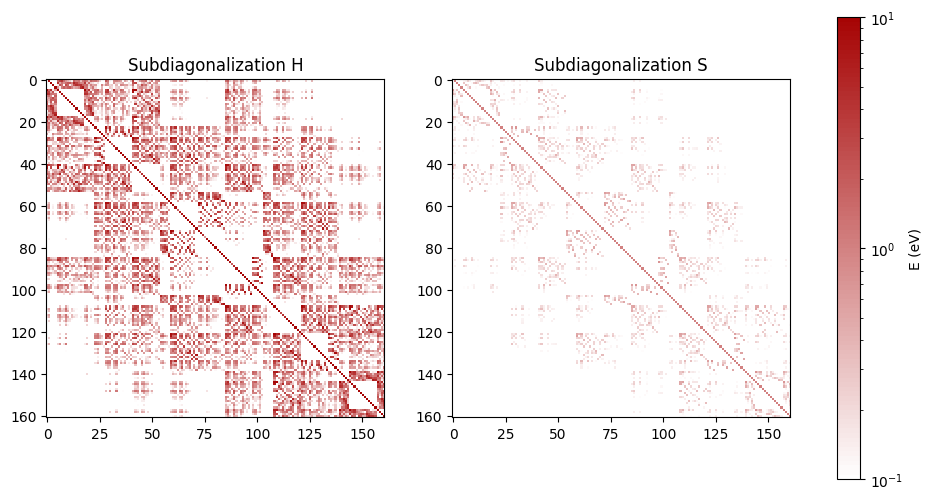

In [12]:
%%px

# Perform subdiagonalization
SUBDIAG_SPECIES = ("C", "N", "H")
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)
Usub, eig = subdiagonalize_atoms(basis, H_lcao[0], S_lcao[0], a=subdiag_indices)

# Rotate matrices
H_subdiagonal = rotate_matrix(H_lcao[0], Usub)[None, ...]
S_subdiagonal = rotate_matrix(S_lcao[0], Usub)[None, ...]

# Extract the bridge regions
bridge_region_H_sub = H_subdiagonal[0, bridge_start:bridge_end, bridge_start:bridge_end]
bridge_region_S_sub = S_subdiagonal[0, bridge_start:bridge_end, bridge_start:bridge_end]

if comm.rank == 0:
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the subdiagonal H matrix for the bridge region
    cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
    ax1.set_title("Subdiagonalization H")

    # Plot the subdiagonal S matrix for the bridge region
    cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
    ax2.set_title("Subdiagonalization S")

    # Add a shared colorbar
    cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
    cbar.set_label('E (eV)')

    plt.show()


### Only C and N 2pz are included in the active space

In [13]:
%%px

# Ensure that the active space and embedding region of the Hamiltonian are orthogonal to each other
lowdin = True

active = {'C':[3], 'N':[3]}

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

# TODO check if this is the right place to do lowdin orthog
if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal[0], S_subdiagonal[0], index_active_region)

    H_lowdin = rotate_matrix(H_subdiagonal[0], Ulow)[None,...]
    S_lowdin = rotate_matrix(S_subdiagonal[0], Ulow)[None,...]


%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

[output:0]

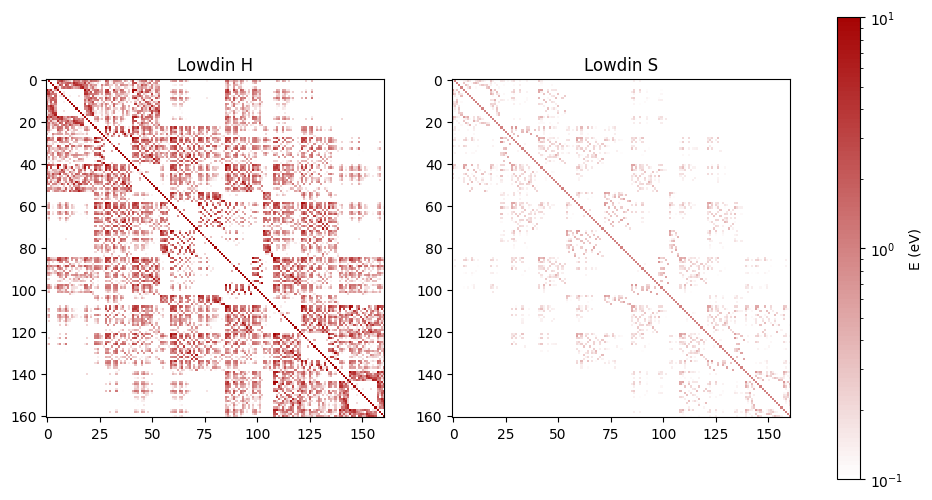

In [14]:
%%px

if comm.rank == 0:
    # Extract the bridge regions
    bridge_region_H_lowdin = H_lowdin[0,bridge_start:bridge_end, bridge_start:bridge_end]
    bridge_region_S_lowdin = S_lowdin[0,bridge_start:bridge_end, bridge_start:bridge_end]

    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the subdiagonal H matrix for the bridge region
    cax1 = ax1.imshow(np.abs(bridge_region_H_lowdin), interpolation='nearest', cmap=cm, norm=norm)
    ax1.set_title("Lowdin H")

    # Plot the subdiagonal S matrix for the bridge region
    cax2 = ax2.imshow(np.abs(bridge_region_S_lowdin), interpolation='nearest', cmap=cm, norm=norm)
    ax2.set_title("Lowdin S")

    # Add a shared colorbar
    cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
    cbar.set_label('E (eV)')

    plt.show()

### Compute hybridization or embedding self-energy

In [15]:
%%px

H_lowdin = H_lowdin.astype(np.complex128)
S_lowdin = S_lowdin.astype(np.complex128)

In [16]:
%%px

# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_lowdin[0], S_lowdin[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='dyson',
                                 eta=eta)

gfp = ProjectedGreenFunction(gf, index_active_region)
hybridization_A = Hybridization(gfp)


In [22]:
%%px

from mpi4py import MPI
from qtpyt.projector import expand

# MPI initialization
comm = MPI.COMM_WORLD
rank = comm.Get_rank()  # Get process rank
size = comm.Get_size()  # Get total number of processes

# Define energy range for the Green's function calculation
de = 0.2
energies = np.arange(-3., 3. + de / 2., de).round(7)
n_A = len(index_active_region)

# Distribute energies among processes
local_energies = np.array_split(energies, size)[rank]  # Each process gets its chunk of energies
local_sigma_A = np.empty((len(local_energies), n_A, n_A), dtype=complex)  # 3D array for local computation

sigma_A = np.empty((len(energies), n_A, n_A), dtype=complex) if rank == 0 else None

# Hybridization calculation on each process's subset of energies
print(f"Process {rank}: Calculating sigma_A for local energies...")
for e, energy in enumerate(local_energies):
    local_sigma_A[e, :, :] = hybridization_A.retarded(energy)

print(f"Process {rank}: Finished sigma_A calculation.")

print("Gathering...")
comm.Gather(local_sigma_A, sigma_A, root=0)
print("Done grathering")

%px:   0%|          | 0/4 [00:00<?, ?tasks/s]

Received Keyboard Interrupt. Sending signal SIGINT to engines...

KeyboardInterrupt



In [ ]:
print(

In [ ]:
%%px

# Gathering sigma_A from all processes using MPI.Gatherv
# Step 1: Calculate the sizes and displacements for Gatherv
local_sizes = np.array([len(local_energies) * n_A * n_A], dtype=int)  # Size of the local data
sizes = None
if rank == 0:
    sizes = np.empty(size, dtype=int)
comm.Gather(local_sizes, sizes, root=0)
print(sizes)
# Step 2: Displacements (for Gatherv)
displacements = None
if rank == 0:
    displacements = np.insert(np.cumsum(sizes[:-1]), 0, 0)

# Step 3: Create the full sigma_A array on rank 0
sigma_A = None
if rank == 0:
    sigma_A = np.empty((energies.size, n_A, n_A), dtype=complex)

# Step 4: Gather the results from all processes using Gatherv
comm.Gatherv(local_sigma_A.flatten(), [sigma_A.flatten(), sizes, displacements, MPI.COMPLEX], root=0)

if rank == 0:
    sigma_A = sigma_A.reshape(energies.size, n_A, n_A)
    print("A: Finished gathering sigma_A")

In [ ]:
%%px

if rank == 0:
    imb = 2  # index of molecule block
    S_molecule = hs_list_ii[imb][1]  # overlap of molecule
    idx_molecule = index_active_region - nodes[imb]  # indices of active region w.r.t molecule

    class DataSelfEnergy(BaseDataSelfEnergy):
        def retarded(self, energy):
            A = super().retarded(energy)
            return expand(S_molecule, A, idx_molecule)

    dse = DataSelfEnergy(energies, sigma_A)
    gf.selfenergies.append((imb, dse))

# Broadcast energies and dse to all processes (if needed)
energies = comm.bcast(energies, root=0)
if rank == 0:
    dse = dse
else:
    dse = None
dse = comm.bcast(dse, root=0)

# Each process computes the transmission for its local energies
local_T_active = np.empty(len(local_energies))
for e, energy in enumerate(local_energies):
    local_T_active[e] = gf.get_transmission(energy)

# Gathering transmission results from all processes
T_active = None
if rank == 0:
    T_active = np.empty(energies.size)
comm.Gather(local_T_active, T_active, root=0)

if rank == 0:
    print("Transmission calculation complete.")

In [ ]:
%%px
import matplotlib.pyplot as plt

if comm.rank == 0:
    plt.plot(E_ref, T_ref, label="references dft")
    plt.plot(energies, T_active, 'o', label="computed dft")

    plt.yscale("log")
    plt.xlim(-2,2)
    plt.ylim(bottom=5e-5)
    plt.legend()

### The entire molecule is included in the active space

In [ ]:
# Ensure that the active space and embedding region of the Hamiltonian are orthogonal to each other
lowdin = True

active = {'C':list(range(13)), 'N':list(range(13)), 'H':list(range(5))}

# Extract the basis for the subdiagonalized region and get their indices
basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

if lowdin:
    Ulow = lowdin_rotation(H_subdiagonal[0], S_subdiagonal[0], index_active_region)

    H_lowdin = rotate_matrix(H_subdiagonal[0], Ulow)[None,...]
    S_lowdin = rotate_matrix(S_subdiagonal[0], Ulow)[None,...]
    
H_lowdin = H_lowdin.astype(np.complex128)
S_lowdin = S_lowdin.astype(np.complex128)

In [ ]:
# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr)
self_energy[1] = PrincipalSelfEnergy(kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id='right')

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# Tridiagonalize the device Hamiltonian and overlap matrices based on the partitioned nodes
hs_list_ii, hs_list_ij = graph_partition.tridiagonalize(nodes, H_lowdin[0], S_lowdin[0])

# Initialize the Green's function solver with the tridiagonalized matrices and self-energies
gf = greenfunction.GreenFunction(hs_list_ii,
                                 hs_list_ij,
                                 [(0, self_energy[0]),
                                  (len(hs_list_ii) - 1, self_energy[1])],
                                 solver='dyson',
                                 eta=eta)

gfp = ProjectedGreenFunction(gf, index_active_region)
hybridization_A = Hybridization(gfp)


In [ ]:
from qtpyt.projector import expand

n_A = len(index_active_region)
sigma_A = np.empty((energies.size, n_A, n_A), dtype=complex)  # Create 3D array

for e, energy in enumerate(energies):
    sigma_A[e, :, :] = hybridization_A.retarded(energy)  # Store the n_A x n_A matrix in sigma_A[e]

imb = 2  # index of molecule block
S_molecule = hs_list_ii[imb][1]  # overlap of molecule
idx_molecule = index_active_region - nodes[imb]  # indices of active region w.r.t molecule

class DataSelfEnergy(BaseDataSelfEnergy):

    def retarded(self, energy):
        A = super().retarded(energy)
        # return expand(S_molecule, A, idx_molecule)
        return A

In [ ]:
# TODO the retarded function implementation of the hybrdiization class implements self energy differently from the DataSelfEnergy, how and why?
dse = DataSelfEnergy(energies, sigma_A)
gf.selfenergies.append((imb, dse))

In [ ]:
# Calculate the transmission function T for each energy in the defined range
T = np.empty(energies.size)
for e, energy in enumerate(energies):
    T[e] = gf.get_transmission(energy)  # Compute transmission at each energy point
gf.selfenergies.pop()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(E_ref, T_ref, label="references dft")
plt.plot(energies, T, 'o', label="computed dft molecule")
plt.plot(energies, T_active, 'o', label="computed dft active C, N 2pz")

plt.yscale("log")
plt.xlim(-2,2)
plt.ylim(bottom=5e-5)
plt.legend()